In [9]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.image as image
import mplhep as hep
import os
hep.style.use([hep.style.ATLAS])
import sys
import datetime
import math
import struct
from pathlib import Path
sys.path.insert(1, '/eos/user/m/mireveri/anubis/osiris/processing/python')
import rawFileReader
import importlib

In [11]:
class rpcHit():
    def __init__(self, channel, time, eta):
        self.time = time
        self.channel = channel
        self.eta = eta

def tdcChanToRPCHit(word,tdc):
    tdcChannel = (word>>24)&0x7f
    tdcHitTime = word&0xfffff
    eta = False
    rpcChan = -1
    if tdc==0:
        if tdcChannel<32:
            rpcChan = tdcChannel
            eta = True
            rpc = 0
        elif tdcChannel<96:
            rpcChan = tdcChannel - 32
            eta = False
            rpc = 0
        else:
            rpcChan = tdcChannel - 96
            eta = True
            rpc = 1
    elif tdc==1:
        if tdcChannel<64:
            rpcChan = tdcChannel
            eta = False
            rpc = 1
        elif tdcChannel<96:
            rpcChan = tdcChannel-64
            eta = True
            rpc = 2
        else:
            rpcChan = tdcChannel-96
            eta = False
            rpc = 2
    elif tdc==2:
        if tdcChannel<32:
            rpcChan = tdcChannel+32
            eta = False
            rpc = 2
        elif tdcChannel<64:
            rpcChan = tdcChannel-32
            eta = True
            rpc = 3
        elif tdcChannel<128:
            rpcChan = tdcChannel-64
            eta = False
            rpc = 3
    elif tdc==3:
        if tdcChannel<32:
            rpcChan = tdcChannel
            eta = True
            rpc = 4
        elif tdcChannel<96:
            rpcChan = tdcChannel-32
            eta = False
            rpc = 4
        else:
            rpcChan = tdcChannel-96
            eta = True
            rpc = 5
    elif tdc==4:
        rpcChan = tdcChannel
        eta = False
        rpc = 5
    return rpc, rpcHit(rpcChan,tdcHitTime*0.8,eta)

In [4]:
def testAlign(rpc1Hits, rpc2Hits):
    minTimes = [300,300]
    minChans = [-1,-1]
    if len(rpc1Hits)<1 or len(rpc2Hits)<1:
        return -1
    for hit in rpc1Hits:
        if hit.time<minTimes[0]:
            minTimes[0]=hit.time
            minChans[0]=hit.channel
    for hit in rpc2Hits:
        if hit.time<minTimes[1]:
            minTimes[1]=hit.time
            minChans[1]=hit.channel
    return abs(minChans[1]-minChans[0])

In [5]:
def calcAvgAlign(eventList,offSet=0):
    mets = []
    for idx, event in enumerate(eventList):
        etaHits = [[] for rpc in range(6)]
        phiHits = [[] for rpc in range(6)]
        if (idx+abs(offSet))<len(eventList):
            if offSet<=0:
                oneIdx = idx+abs(offSet)
                twoIdx = idx
            else:
                oneIdx = idx
                twoIdx = idx+offSet
            for word in eventList[oneIdx].tdcEvents[1].words:
                rpc, thisHit = tdcChanToRPCHit(word,1)
                if thisHit.eta:
                    etaHits[rpc].append(thisHit)
                else:
                    phiHits[rpc].append(thisHit)
            for word in eventList[twoIdx].tdcEvents[0].words:
                rpc, thisHit = tdcChanToRPCHit(word,0)
                if thisHit.eta:
                    etaHits[rpc].append(thisHit)
                else:
                    phiHits[rpc].append(thisHit)        

            etOff = testAlign(etaHits[1],etaHits[2])
            phOff = testAlign(phiHits[0],phiHits[1])
            if etOff>=0 and phOff>=0:
                mets.append(math.sqrt(etOff*etOff+phOff*phOff))
    if len(mets)>0:
        return sum(mets)/len(mets)
    else:
        return 100

In [6]:
def doRealign(fReader, events):
    aligned = True
    alignMet = calcAvgAlign(events)
    if alignMet>10 and alignMet<100:
        aligned = False
        for testOffset in [1,2,-1,-2]:
            testAlignMet = calcAvgAlign(events,testOffset)
            if testAlignMet<10:
                if testOffset>0:
                    for fakeEvent in range(testOffset):
                        fReader.evtBuilder.insertFakeEvent(tdc=1)
                else:
                    for fakeEvent in range(abs(testOffset)):
                        fReader.evtBuilder.insertFakeEvent(tdc=0)
                aligned = True
                print("Found a new alignment, offsetting by",testOffset, "idx is", processedEvents)
                break
    return aligned

In [7]:
allFpaths = []
for dirname in os.listdir('/eos/atlas/atlascerngroupdisk/proj-anubis/proANUBIS/data/24_05/'):
    for file in os.listdir('/eos/atlas/atlascerngroupdisk/proj-anubis/proANUBIS/data/24_05/'+dirname):
        if 'sys' not in file:
            if 'raw' in file:
                allFpaths.append('/eos/atlas/atlascerngroupdisk/proj-anubis/proANUBIS/data/24_05/'+dirname+'/'+file)

In [12]:
importlib.reload(rawFileReader)
fReader = rawFileReader.fileReader(allFpaths[1])
processedEvents = 0
events = []
lastWasBad = False
while processedEvents<300000:
    if not fReader.readBlock():
        print("Bad Block Read")
        break
    if(fReader.hasEvents()):
        for event in fReader.getEvents():
            events.append(event)
            processedEvents = processedEvents+1
            if processedEvents%200==0 and processedEvents>0:
                aligned = doRealign(fReader,events[-200:])
                if lastWasBad and not aligned:
                    print("Two bad aligns in a row, processedEvents is",processedEvents)
                elif not aligned:
                    lastWasBad = True
                else:
                    lastWasBad = False

Found a new alignment, offsetting by 1 idx is 200
Found a new alignment, offsetting by 1 idx is 27000
Found a new alignment, offsetting by 1 idx is 38200
Found a new alignment, offsetting by -1 idx is 64000
Found a new alignment, offsetting by 1 idx is 93800
Found a new alignment, offsetting by -1 idx is 101400
Found a new alignment, offsetting by 2 idx is 142600
Found a new alignment, offsetting by 1 idx is 155600
Found a new alignment, offsetting by 1 idx is 187200
Found a new alignment, offsetting by 1 idx is 192800
Found a new alignment, offsetting by 1 idx is 201400
Found a new alignment, offsetting by 1 idx is 204800
Found a new alignment, offsetting by 1 idx is 213600
Found a new alignment, offsetting by 1 idx is 215600
Found a new alignment, offsetting by -1 idx is 230400
Found a new alignment, offsetting by 1 idx is 240200
Found a new alignment, offsetting by 1 idx is 264200
Found a new alignment, offsetting by 1 idx is 267200
Found a new alignment, offsetting by -1 idx is 273

In [13]:
offsetTest = []
for offSet in range(4):
    offsetTest.append([])
    print(offSet)
    for idx, event in enumerate(events):
        etaHits = [[] for rpc in range(6)]
        phiHits = [[] for rpc in range(6)]
        if (idx+offSet)<len(events):
            if offSet>25:
                oneIdx = idx+offSet-25
                twoIdx = idx
            else:
                oneIdx = idx
                twoIdx = idx+offSet
            for word in events[oneIdx].tdcEvents[1].words:
                rpc, thisHit = tdcChanToRPCHit(word,1)
                if thisHit.eta:
                    etaHits[rpc].append(thisHit)
                else:
                    phiHits[rpc].append(thisHit)
            for word in events[twoIdx].tdcEvents[0].words:
                rpc, thisHit = tdcChanToRPCHit(word,0)
                if thisHit.eta:
                    etaHits[rpc].append(thisHit)
                else:
                    phiHits[rpc].append(thisHit)        

            etOff = testAlign(etaHits[1],etaHits[2])
            phOff = testAlign(phiHits[0],phiHits[1])
            if etOff>=0 and phOff>=0:
                offsetTest[-1].append(math.sqrt(etOff*etOff+phOff*phOff))
            else:
                offsetTest[-1].append(-1)
            #if etOff>0:
            #    offsetTest[-1].append(etOff)   

0
1
2
3


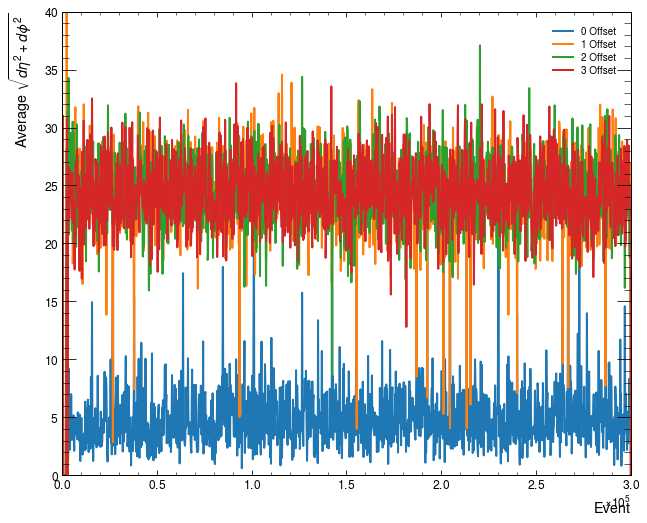

In [17]:
binsx = [x*200 for x in range(3000)]
noffs = 4
offsets = [[0 for xbin in binsx] for offset in range(noffs)]
offsetOne = [0 for xbin in binsx]
for testOff in range(noffs):
    xbin=0
    counts=0
    for idx, offset in enumerate(offsetTest[testOff]):
        if offset>-0.5:
            offsets[testOff][xbin]=offsets[testOff][xbin]+offset
            counts = counts+1
        if idx%200==0 and idx>0:
            if counts>0:
                offsets[testOff][xbin]=offsets[testOff][xbin]/counts
            xbin=xbin+1
            counts=0
    if counts>0:
        offsets[testOff][xbin]=offsets[testOff][xbin]/counts

fig, ax = plt.subplots(figsize=(10, 8))
for idx, offsethist in enumerate(offsets):
    ax.plot(binsx,offsethist,label=str(idx)+' Offset')

ax.set_xlim(0,300000)
ax.set_ylim(0,40)
ax.legend()
ax.set_ylabel('Average $\sqrt{d\eta^2+d\phi^2}$')
ax.set_xlabel('Event')
plt.show()